In [42]:
from __future__ import division
import os
import numpy as np
from keras.models import load_model
from keras import backend as K
from keras.backend import binary_crossentropy
import tifffile as tif
from skimage import img_as_ubyte
import argparse
import matplotlib.pyplot as plt
import re

smooth = 1e-12
K.set_image_dim_ordering('tf')

num_channels = 3
num_mask_channels = 1


def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)


def predict(model, image):
    """ Predict mask of image

    :param image: image in numpy array with size (H, W, Channels)
    :return: list of binary masks in numpy array format (Categories, H, W)
    """
    res = _bin_mask(model.predict(image[np.newaxis, ...]))
    mask = np.squeeze(res)

    return mask

def _bin_mask(image):
    """ Clip the image into binary image
    When pixel in [0, 0.5) => 0, else => 1

    :param image: image numpy array
    :return: binary image
    """
    return np.clip(image, 0, 1) >= 0.5


def binary_accuracy(y_true, y_pred):
    #a = y_true == y_pred
    #print np.max(a), np.sum(a)
    return np.sum(y_true == y_pred) / y_true.size


def binary_recall(y_true, y_pred):
    idx = np.where(y_true == 1)
    return np.sum(y_true[idx] == y_pred[idx]) / y_true[idx].size


def binary_precision(y_true, y_pred):
    idx = np.where(y_pred == 1)
    return np.sum(y_true[idx] == y_pred[idx]) / y_pred[idx].size


def search_best_model(path):
    pattern = re.compile(r'(?<=-)(\d+\.\d+)(?=\.)')
    files = os.listdir(path)
    loss = float('inf')
    model_file = ''
    for fn in files:
        tem_loss = float(pattern.search(fn).group())
        if tem_loss < loss:
            loss = tem_loss
            model_file = fn
    return os.path.join(path, model_file)

In [43]:
cate = 'Baresoil'    # input obj category
weight_path = '../checkpoints/'+cate
weight_file = search_best_model(weight_path)
model = load_model(
    weight_file,
    custom_objects={
        u'jaccard_coef_loss': jaccard_coef_loss,
        u'jaccard_coef_int': jaccard_coef_int
    })


../data/Baresoil/542.tif
(1024, 1024, 3) 3145728 1023.0
0.6763413659965384
0.7425573727891377


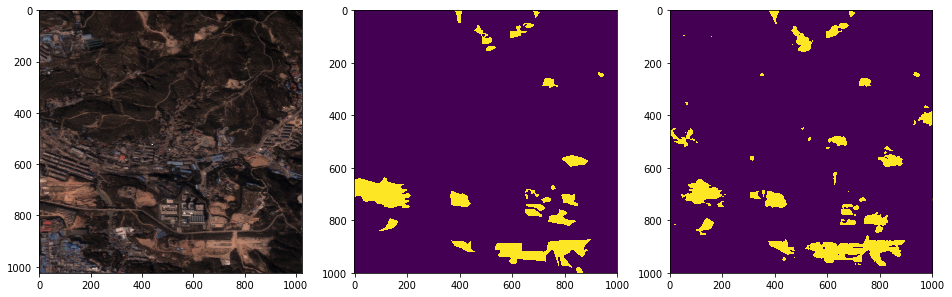

In [44]:
idx = 542   #  input img name
img_path = '../data/' + cate
img_file = os.path.join(img_path, '%d.tif' % idx)

print img_file
img = tif.imread(img_file).astype(np.float16)
print img.shape, img.size, np.max(img)
for c in range(num_channels):
    img[:, :, c] = (img[:, :, c] - img[:, :, c].min()) / (img[:, :, c].max() - img[:, :, c].min())
mask_pred = predict(model, img)
#print mask_pred.shape, mask_pred.size, np.max(mask_pred)
mask = img_as_ubyte(tif.imread(os.path.join(img_path, '%d_mask.tif' % idx))).astype(np.float16)[12:1012, 12:1012]
#print mask.shape, mask.size, np.max(mask)
print binary_precision(mask, mask_pred)
print binary_recall(mask, mask_pred)

plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.imshow((img*255).astype(np.uint8))
plt.subplot(1, 3, 2)
plt.imshow(mask.astype(np.uint8)*255)
plt.subplot(1, 3, 3)
plt.imshow(mask_pred.astype(np.uint8)*255)